In [149]:
import os
import random
import re
import time

import pandas as pd
import numpy as np
# import warnings
import warnings
import seaborn as sns
import os
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier 

import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# ignore warnings
warnings.filterwarnings("ignore")
# Any results you write to the current directory are saved as output.

## Dataset

Este Dataset foi disponibilizado no site da Kaggle, e contem 60.000 perguntas realizadas entre 2016-2020 no site Stack Overflow. Vamos então fazer a leitura do arquivo CSV

In [120]:
df = pd.read_csv('./input/data.csv')

In [121]:
df.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            60000 non-null  int64 
 1   Title         60000 non-null  object
 2   Body          60000 non-null  object
 3   Tags          60000 non-null  object
 4   CreationDate  60000 non-null  object
 5   Y             60000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.7+ MB


A partir disso, vemos: 

- Não existem dados NaN ( que representam valores numéricos indefinidos ou irrepresentáveis )

- Existem 6 colunas, e somente A 'Id' possui dtype numérico

### Aplicando algumas transformações

- Primeiro, vamos transformar os itens da coluna 'CreationDate' para o dtype adequado

In [123]:
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            60000 non-null  int64         
 1   Title         60000 non-null  object        
 2   Body          60000 non-null  object        
 3   Tags          60000 non-null  object        
 4   CreationDate  60000 non-null  datetime64[ns]
 5   Y             60000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2.7+ MB


- Criarei uma coluna para receber o ano em que a pergunta foi feito

In [124]:
df['year'] = df['CreationDate'].dt.year
df.head()

,Id,Title,Body,Tags,CreationDate,Y,year
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,2016
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT,2016
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,2016
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,2016
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,2016


### Agora aplicando alguns pré-processamentos de Data

In [125]:
df['Body'] = df['Title'] + " " + df['Body']

In [126]:
# Clean the data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text

df['Body'] = df['Body'].apply(clean_text)
df.head()

,Id,Title,Body,Tags,CreationDate,Y,year
0,34552656,Java: Repeat Task Every Random Seconds,java repeat task every random seconds pim alre...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,2016
1,34552974,How to get all the child records from differen...,how to get all the child records from differen...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT,2016
2,34553034,Why are Java Optionals immutable?,why are java optionals immutable pid like to u...,<java><optional>,2016-01-01 02:03:20,HQ,2016
3,34553174,Text Overlay Image with Darkened Opacity React...,text overlay image with darkened opacity react...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,2016
4,34553318,Why ternary operator in swift is so picky?,why ternary operator in swift is so picky pthe...,<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,2016


Agora, vou remover as 'stopwords' ou palavras vazias:

In [127]:
#def remove_stopword
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import nltk
  
example_sent = "This is a sample sentence, showing off the stop words filtration."  #Esta é uma frase exemplo, mostrando a filtragem das stop words
stop_words = set(stopwords.words('english')) 

def remove_stopword(words):
    list_clean = [w for w in words.split(' ') if not w in stop_words]
    return ' '.join(list_clean)

df['Body'] = df['Body'].apply(remove_stopword)
df.head()

,Id,Title,Body,Tags,CreationDate,Y,year
0,34552656,Java: Repeat Task Every Random Seconds,java repeat task every random seconds pim alre...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,2016
1,34552974,How to get all the child records from differen...,get child records different tables based given...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT,2016
2,34553034,Why are Java Optionals immutable?,java optionals immutable pid like understand j...,<java><optional>,2016-01-01 02:03:20,HQ,2016
3,34553174,Text Overlay Image with Darkened Opacity React...,text overlay image darkened opacity react nati...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,2016
4,34553318,Why ternary operator in swift is so picky?,ternary operator swift picky pthe question sim...,<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,2016


## Visualizando

- Vamos dar uma olhada nas questões feitas por ano

In [128]:
df1 = df.groupby(['year']).size().reset_index(name='counts')
df1.head()

,year,counts
0,2016,20343
1,2017,16104
2,2018,13811
3,2019,8606
4,2020,1136


Text(0.5, 1.0, 'Perguntas Stack Overflow')

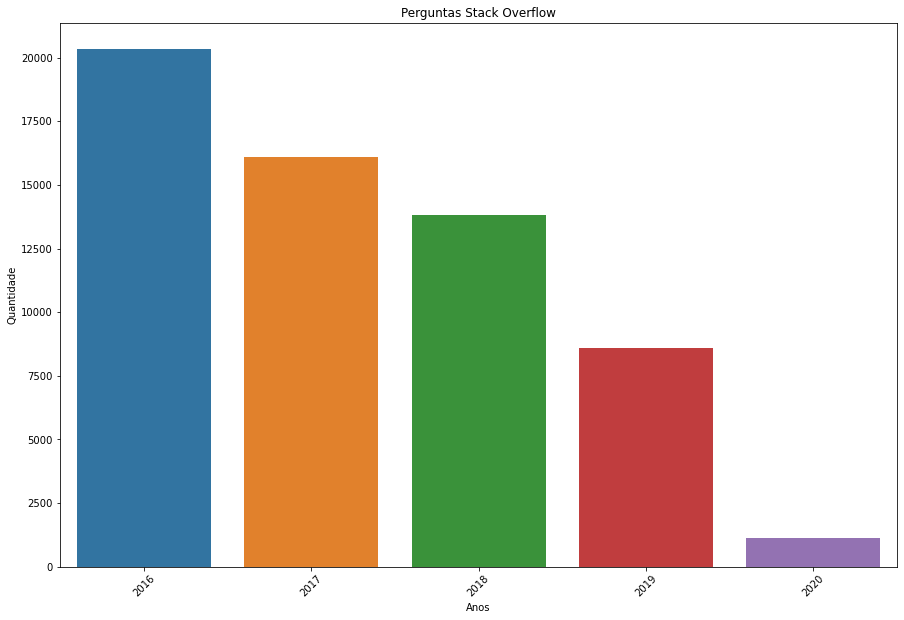

In [129]:
# visualização
plt.figure(figsize=(15,10))
sns.barplot(x=df1['year'], y=df1['counts'])
plt.xticks(rotation= 45)
plt.xlabel('Anos')
plt.ylabel('Quantidade')
plt.title('Perguntas Stack Overflow')

- Vamos agora visualizar a quantidade de perguntas por classificação

In [130]:
df1 = df.groupby(['Y']).size().reset_index(name='counts')
df1.head()

,Y,counts
0,HQ,20000
1,LQ_CLOSE,20000
2,LQ_EDIT,20000


Text(0.5, 1.0, 'Quantidade de perguntas por classificação')

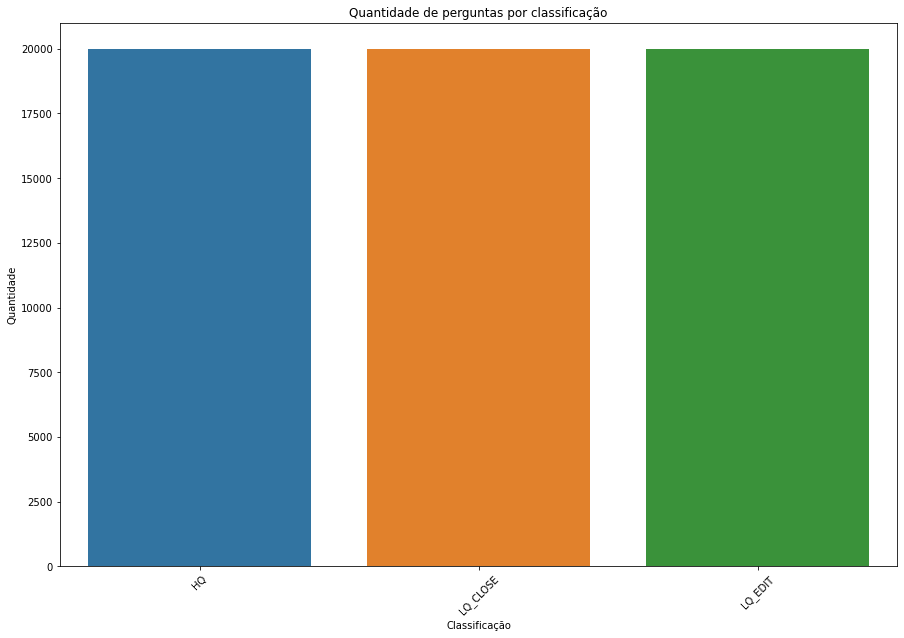

In [131]:
#visualização
plt.figure(figsize=(15,10))
sns.barplot(x=df1['Y'], y=df1['counts'])
plt.xticks(rotation= 45)
plt.xlabel('Classificação')
plt.ylabel('Quantidade')
plt.title('Quantidade de perguntas por classificação')

## Transformando o Dataset para Modelar

- Nosso primeiro modelo terá como objetivo resolver um problema de classificação
- Para resolver essa questão, deveremos criar um modelo que consiga, com precisão, definir em qual categoria uma questão deverá está com base nos outros elementos

- Primeiro, dividirei o dataset em dois: Train e Test
    - Servirá para, ao fazer a modelagem, poder testar o modelo em uma parte do dataset que não foi utilizado para a modelagem
- Depois, transformarei os elementos das coluna 'body'(corpo) em vetores

In [132]:
N = len(data)
TRAIN_PERC = 0.8
ind_train = np.random.rand(N) < TRAIN_PERC
train, test = df[ind_train], df[~ind_train]
print(f'len(train)={len(train)}; len(test)={len(test)}')

len(train)=47890; len(test)=12110


In [133]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.Body)
X_train_counts.shape

(47890, 354390)

In [134]:
X_test_counts = count_vect.transform(test.Body)
X_test_counts.shape

(12110, 354390)

In [138]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape


(47890, 354390)

In [139]:
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

(12110, 354390)

## Modelos

In [144]:
clf_dict = {
    'LogisticRegression': LogisticRegression,
    'MultinomialNB': MultinomialNB,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'SGDClassifier': SGDClassifier,
    'Perceptron': Perceptron,
    'RidgeClassifier': RidgeClassifier,
    'LinearSVC': LinearSVC,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier,
    #'MLPClassifier': MLPClassifier,
}

In [145]:
def get_accuracy(clf, n_estimators=None, max_depth=None, learning_rate=None, max_iter=None):
    start = time.time()
    text_clf = clf(**params).fit(X_train_tfidf, train.Y)
    predicted = text_clf.predict(X_test_tfidf)
    print(f'Accuracy gets in {round(time.time()-start, 2)}s.')
    return np.mean(predicted == test.Y)

result_dict = {}

for clf_str, clf_fn in clf_dict.items():
    if clf_str == 'LogisticRegression':
        params = {'max_iter': 200}
    elif clf_str == 'RandomForestClassifier':
        params = {'n_estimators': 50,
                  'max_depth': 10}
    elif clf_str == 'DecisionTreeClassifier':
        params = {'max_depth': 10}
    elif clf_str == 'GradientBoostingClassifier':
        params = {'n_estimators': 50,
                  'learning_rate': 0.1}
    else:
        params = {}
    accuracy = get_accuracy(clf=clf_fn, **params)
    result_dict[clf_str] = accuracy
    print(f"Clf={clf_str}; Accuracy={accuracy}")

Accuracy gets in 59.48s.
Clf=LogisticRegression; Accuracy=0.877869529314616
Accuracy gets in 0.25s.
Clf=MultinomialNB; Accuracy=0.8034682080924855
Accuracy gets in 8.45s.
Clf=DecisionTreeClassifier; Accuracy=0.7620148637489678
Accuracy gets in 0.93s.
Clf=SGDClassifier; Accuracy=0.8593724194880265
Accuracy gets in 0.61s.
Clf=Perceptron; Accuracy=0.8548307184145334
Accuracy gets in 3.42s.
Clf=RidgeClassifier; Accuracy=0.8590421139554087
Accuracy gets in 2.21s.
Clf=LinearSVC; Accuracy=0.8805945499587118
Accuracy gets in 2.04s.
Clf=RandomForestClassifier; Accuracy=0.7521056977704377
Accuracy gets in 219.8s.
Clf=GradientBoostingClassifier; Accuracy=0.7992568125516102


In [146]:
result_dict = {
    k: v
    for k, v in sorted(
        result_dict.items(),
        key=lambda x: x[1],
        reverse=True
    )
}

result_dict

{'LinearSVC': 0.8805945499587118,
 'LogisticRegression': 0.877869529314616,
 'SGDClassifier': 0.8593724194880265,
 'RidgeClassifier': 0.8590421139554087,
 'Perceptron': 0.8548307184145334,
 'MultinomialNB': 0.8034682080924855,
 'GradientBoostingClassifier': 0.7992568125516102,
 'DecisionTreeClassifier': 0.7620148637489678,
 'RandomForestClassifier': 0.7521056977704377}

- Verificamos um percentual de 88% de precisão sem nenhum ajuste 

## Optimizando os modelos com ajustes de parâmetros

In [150]:
DIM_Logistic = [
    Integer(100, 400, name='max_iter')
]

DIM_SVC = [
    Real(1e-5, 1, name='tol', prior='log-uniform'),
    Real(0.1, 1.5, name='C', prior='log-uniform')
]

DIM_SGDC = [
    Real(1e-5, 1e-2, name='alpha', prior='log-uniform')
]

DIM_RF = [
    Integer(1, 100, name='n_estimators'),
    Integer(5, 30, name='max_depth')
]

DIMS = {
    'LogisticRegression': DIM_Logistic,
    'LinearSVC': DIM_SVC,
    'SGDClassifier': DIM_SGDC,
    'RandomForestClassifier': DIM_RF
}

In [151]:
def optimize(clf_str='LinearSVC'):
    
    dimensions = DIMS[clf_str]
    print(dimensions)
    
    @use_named_args(dimensions=dimensions)
    def fitness(**params):
        clf = clf_dict[clf_str](**params)
        text_clf = clf.fit(X_train_tfidf, train.Y)
        predicted = text_clf.predict(X_test_tfidf)
        accuracy = np.mean(predicted == test.Y)
        print(f'accuracy={accuracy} with params={params}')
        return -1.0 * accuracy
    
    res = gp_minimize(func=fitness,
                      dimensions=dimensions,
                      acq_func='EI', # Expected Improvement.
                      n_calls=10,
                      random_state=666)
    print(f'best accuracy={-1.0 * res.fun} with {res.x}')
    return res

In [152]:
res_dict = {}
for clf_str, clf_dim in DIMS.items():
    print(f'start optimizaton for {clf_str}')
    res = optimize(clf_str=clf_str)
    res_dict[clf_str] = res

start optimizaton for LogisticRegression
[Integer(low=100, high=400, prior='uniform', transform='identity')]
accuracy=0.8776218001651528 with params={'max_iter': 131}
accuracy=0.8777043765483071 with params={'max_iter': 163}
accuracy=0.8781998348472337 with params={'max_iter': 139}
accuracy=0.8777869529314616 with params={'max_iter': 325}
accuracy=0.8777869529314616 with params={'max_iter': 201}
accuracy=0.877869529314616 with params={'max_iter': 173}
accuracy=0.8777043765483071 with params={'max_iter': 178}
accuracy=0.8777869529314616 with params={'max_iter': 184}
accuracy=0.8777869529314616 with params={'max_iter': 239}
accuracy=0.877869529314616 with params={'max_iter': 170}
best accuracy=0.8781998348472337 with [139]
start optimizaton for LinearSVC
[Real(low=1e-05, high=1, prior='log-uniform', transform='identity'), Real(low=0.1, high=1.5, prior='log-uniform', transform='identity')]
accuracy=0.8738232865400496 with params={'tol': 3.2590317060358435e-05, 'C': 0.17723383193111547}
ac

## Maior precisão por modelo e seus respectivos hyperparameters

In [153]:
for clf_str, res in res_dict.items():
    hyperparameters_label = [hp.name for hp in DIMS[clf_str]]
    best_hyperparameters = dict(zip(hyperparameters_label, res.x))
    print(f'clf={clf_str}\nbest accuracy={-res.fun}\nbest hyperparameters={best_hyperparameters}\n')

clf=LogisticRegression
best accuracy=0.8781998348472337
best hyperparameters={'max_iter': 139}

clf=LinearSVC
best accuracy=0.8813377374071015
best hyperparameters={'tol': 5.9918414788335004e-05, 'C': 0.7310856330548163}

clf=SGDClassifier
best accuracy=0.879851362510322
best hyperparameters={'alpha': 2.031669923181096e-05}

clf=RandomForestClassifier
best accuracy=0.8122213047068538
best hyperparameters={'n_estimators': 77, 'max_depth': 29}



# Conclusão

- Foi obtido um percentual de 88% de precisão para a classificação das perguntas